**This notebook does exploratory analysis on celeba-hq. It does not require any of the projections - it just looks at functions of the original images.**

In [3]:
%load_ext autoreload
%autoreload 2
from os.path import join as oj
import sys
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
import config
import data
import util
from config import *
df = data.load_all_labs()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
df['Race=black'] = (df['race4_pred'] == 'Black').astype(int)

## show some celeb ims

In [2]:
ims = np.array([mpimg.imread(oj(DIR_IMS, fname))
                for fname in df.fname_final.values[:200]])

In [ ]:
util.plot_grid(ims.reshape(8, 25, *ims.shape[1:]))

In [ ]:
N_CELEBS = 6
d = df[df['count_with_this_id'] > 20]
# d = d[d['skin-color'] == 0] # filter by skin color
# d = d[d['gender'] == 1] # filter by skin color

for i in d['id'].unique()[:N_CELEBS]:
    ids = d[d.id == i]
#     print(ids.shape)
    ims = np.array([mpimg.imread(oj(DIR_IMS, fname))
                    for fname in ids.fname_final.values])
#     print(ims.shape)
    util.plot_row(ims)
    plt.show()

## look at image statistics

In [ ]:
# plt.grid(zorder=-1)
plt.hist(df[df['gender'] == 0]['count_with_this_id'], label='Female')
plt.hist(df[df['gender'] == 1]['count_with_this_id'], label='Male', alpha=0.5)
plt.xlabel('Number of images with same id\nin celeb-a-hq (30k images)')
plt.legend()
plt.show()
# plt.hist(df[df['gender'] == 1])

## label correlations

In [ ]:
# df.columns.values

In [ ]:
keys = ['gender', 'makeup', 'Eyeglasses', 'age', 'Race=black']
d = df[keys]
idxs = df['gender'] == 0
plt.figure(dpi=500)
viz.corrplot(d.corr())
plt.title('Correlations')
keys = np.array([k.capitalize() for k in keys])
# keys = labs.columns.str.capitalize().values
plt.xticks(np.arange(keys.size), keys, rotation='vertical')
plt.yticks(np.arange(keys.size), keys)
plt.colorbar()

means = d.groupby('gender').mean()

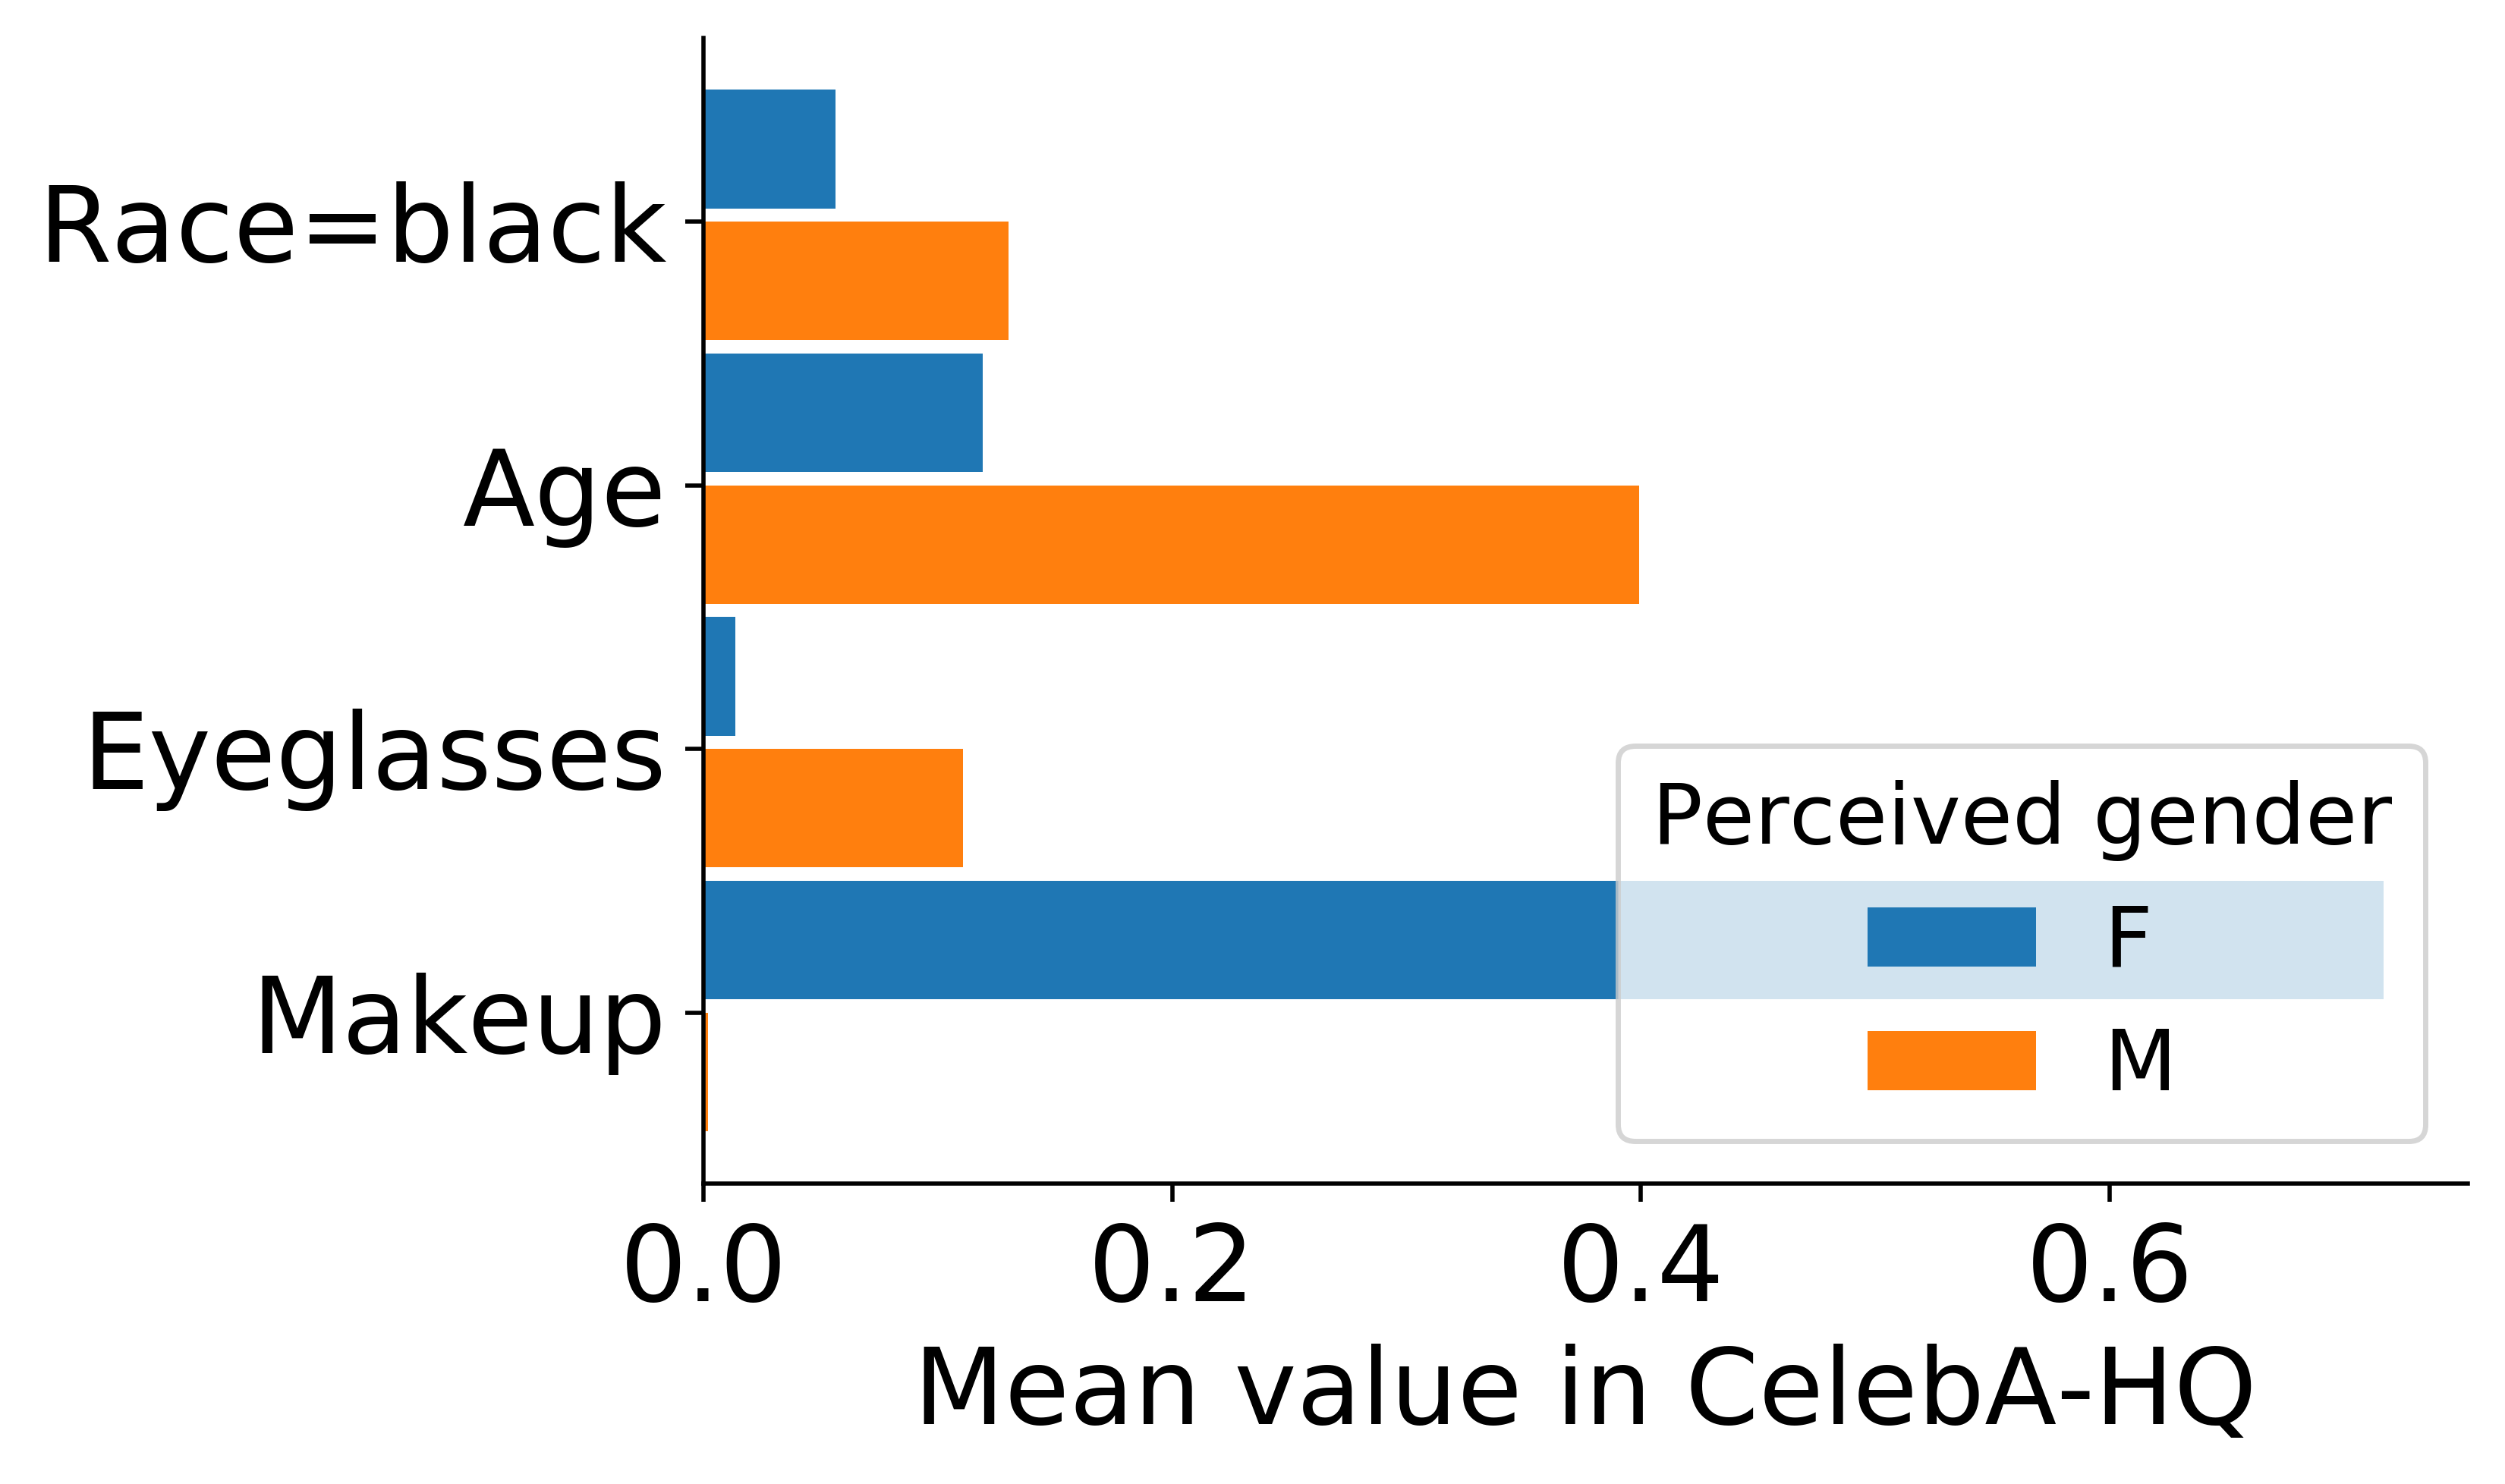

In [17]:
BAR_SIZE = 0.45
cols = [s.capitalize() for s in means.columns.values]
plt.figure(dpi=500)
plt.barh(np.arange(len(cols)) + 0.5, means.iloc[0], height=BAR_SIZE, label='F')
plt.barh(np.arange(len(cols)), means.iloc[1], height=BAR_SIZE, label='M')
plt.legend(title='Perceived gender', loc='lower right')
plt.yticks(np.arange(len(cols)) + BAR_SIZE / 2, cols)
plt.xlabel('Mean value in CelebA-HQ')
plt.show()

## benchmarking facial dists

In [128]:
'''
# facial dists contains the distances between the first 2 images of every id
facial_dists = pkl.load(open(oj(config.PROCESSED_DIR, '12_facial_dists.pkl'), 'rb'))

# for each id, calculate the mean value of each attribute and store in df_facial
ks = [k for k in df.keys() if not '_scores' in k] # list(labs_full.keys()) + list(labs.keys()) + 
vals = {
    k: [] for k in ks
}
for i in tqdm(facial_dists['ids']):
    d = df[ks]
    d = d[d.id == i]
    modes = d.mode()
    for k in ks:
        vals[k].append(modes[k])
df_facial = pd.DataFrame.from_dict({**vals, **facial_dists} )
df_facial.to_pickle(open(oj(config.PROCESSED_DIR, '12_facial_dists_df.pkl'), 'wb'))
'''
df_facial = pd.read_pickle(open(oj(config.PROCESSED_DIR, '12_facial_dists_df.pkl'), 'rb'))
for k in df_facial.keys():
    if 'race' in k:
        df_facial[k] = [df_facial[k][i][0] for i in range(df_facial.shape[0])]

In [ ]:
df_facial['Race'] = (df_facial['race4_pred'] == 'Black').astype(int)

attr = 'gender'
attr_labs = ['M', 'F']
attr = 'Eyeglasses'
attr_labs = ['Yes', 'No']
attr = 'Race'
attr_labs = ['Black', 'White']

idxs0 = (df_facial[attr] > 0.5)
idxs1 = ~idxs0

d0 = df_facial[idxs0]['facial_dists']
similarity_0 = 1 - d0
d1 = df_facial[idxs1]['facial_dists']
similarity_1 = 1 - d1
plt.figure(dpi=500)
acc0 = f'{np.mean(d0 < 0.6):0.2f}'
acc1 = f'{np.mean(d1 < 0.6):0.2f}'
kwargs = {
    'cumulative': True,
    'density': True,
    'bins': 20
}
plt.hist(similarity_0, label=attr_labs[0] + f' (acc: {acc0})', **kwargs)
plt.hist(similarity_1, label=attr_labs[1] + f'  (acc: {acc1})', alpha=0.5, **kwargs)
plt.axvline(1 - 0.6, linestyle='--', color='gray', alpha=1)
plt.legend(title=attr.capitalize(), loc='lower right', framealpha=1)
plt.yscale('log')
plt.xlabel('Facial similarity (dllib) for image\npairs with the same identity')
plt.ylabel('Cumulative density')
plt.show()

**box plots**

In [ ]:
attr = 'gender'
attr_labs = ['M', 'F']
# attr = 'Eyeglasses'
# attr_labs = ['No', 'Yes']

idxs_attr = (df_facial[attr] > 0.5)
d0 = df_facial[idxs_attr]['facial_dists']
d1 = df_facial[~idxs_attr]['facial_dists']
plt.figure(dpi=300)
plt.boxplot([d0, d1], vert=False, widths=0.6)
plt.axvline(0.6, linestyle='--')
plt.yticks(np.arange(1, 3), attr_labs)
plt.ylabel(attr.capitalize())
plt.xlabel('Facial distance\n(Lower means it is working better)')
print(f'acc {attr_labs[0]} {np.mean(d0 < 0.6):0.2f} acc {attr_labs[1]} {np.mean(d1 < 0.6):0.2f}')
plt.show()